# Local crystallography

Here we will play with an atomically resolved image where the atoms have been found, and perform local crystallography to get an idea about the neighborhoods. The STEM image is of $Mo_{0.45}Re_{0.55}S_{2}$ was by Wu Zhou and Matthew Chisholm (ORNL) and are taken from <i> Yang et al. </i> Adv. Mater. <b>30</b>, 1803477 (2018) <a href="https://onlinelibrary.wiley.com/doi/pdf/10.1002/adma.201803477">(Link)</a> . We recommend you upload your own image and test it out. 

The paper on which this notebook is based is available on arxiv <a href = "https://arxiv.org/pdf/2006.10001">here</a>.

The original paper which introduced the idea of Local Crystallography is Belianinov et al. Nat Commun. <b>6</b>, 7801 (2015) <a href = "https://www.nature.com/articles/ncomms8801">(Link)</a>

# Load modules

In [3]:
#Load pycroscopy from master branch to get the latest
!pip install git+https://github.com/pycroscopy/pycroscopy@master
!pip3 install pyro-ppl

  Cloning https://github.com/pycroscopy/pycroscopy (to revision master) to /tmp/pip-req-build-i7us6znm
  Running command git clone -q https://github.com/pycroscopy/pycroscopy /tmp/pip-req-build-i7us6znm
     |████████████████████████████████| 81kB 6.1MB/s 
     |████████████████████████████████| 174kB 13.4MB/s 
     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 788kB 10.8MB/s 
     |████████████████████████████████| 481kB 26.8MB/s 
     |████████████████████████████████| 358kB 36.9MB/s 
  Created wheel for pycroscopy: filename=pycroscopy-0.60.7-py2.py3-none-any.whl size=525835 sha256=cb6d2a8196dc2a5deb6cdf04a321fc7e1ea24b8e8b3765469fe09fb3f2596f6c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2vjhlffa/wheels/49/b6/f7/fde4fa7ce004ab45847b480467b040170004d7cb53ee44bf8f
  Created wheel for numpy-groupies: filename=numpy_groupies-0.9.7-cp36-none-any.whl size=21325 sha256=62236f9d12d2f0a3321bc8fd4d6a1aec7662983b4a5e016718aeb82da6120d5d
  Stored

     |████████████████████████████████| 614kB 8.1MB/s 


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pycroscopy
from pycroscopy.analysis.contrib.atoms import Atoms

/usr/local/lib/python3.6/dist-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


In [5]:
#Load the data
!wget -O "re_55.npy" https://www.dropbox.com/s/4v306p72r2oa2ef/re55_cropped_image.npy?dl=1
!wget -O "atom_positions.npy" https://www.dropbox.com/s/tsqf2plxyp9zusk/re55_atom_positions_refined.npy?dl=1


--2020-12-10 16:53:12--  https://www.dropbox.com/s/4v306p72r2oa2ef/re55_cropped_image.npy?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.1, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/4v306p72r2oa2ef/re55_cropped_image.npy [following]
--2020-12-10 16:53:12--  https://www.dropbox.com/s/dl/4v306p72r2oa2ef/re55_cropped_image.npy
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9910b4bdfecf42ef79f7646e87.dl.dropboxusercontent.com/cd/0/get/BE0jOxNWsF65MqDN0TdWc8v_KfTDR9Kvz9WRvL5Vfba4ga3I7l9SAKuCtgf1qD38zVfnUtMyFRckLqH1wEOtCqfSkvFqaEm51bEoOiCqlH885p9Gy3N7SG7UvS5NjAK4c30/file?dl=1# [following]
--2020-12-10 16:53:12--  https://uc9910b4bdfecf42ef79f7646e87.dl.dropboxusercontent.com/cd/0/get/BE0jOxNWsF65MqDN0TdWc8v_KfTDR9Kvz9WRvL5Vfba4ga3I7l9SAKuCtgf1qD38zVfnUtMyFRckLqH1w

# Visualize the image and the atoms

## Plot the image

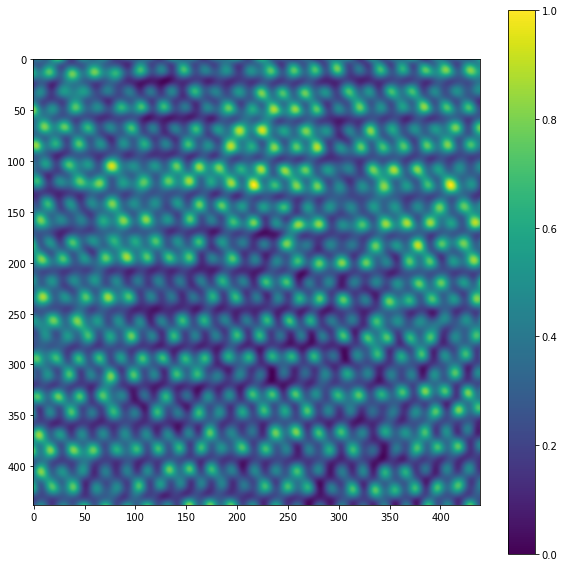

In [6]:
data_re55 = np.load('re_55.npy')
data_re55 = (data_re55 - np.min(data_re55)) / (np.max(data_re55) - np.min(data_re55))

plt.figure(figsize = (10,10))
plt.imshow(data_re55)
plt.colorbar()

## Load atom positions

Here we will work with pre-computed atomic coordinates. You can use your choice of algorithm for this part; for instance, you can use <a href = "https://github.com/pycroscopy/atomai">AtomAI's</a> atom finding neural networks. But regardless, we just need the atomic coordinates. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


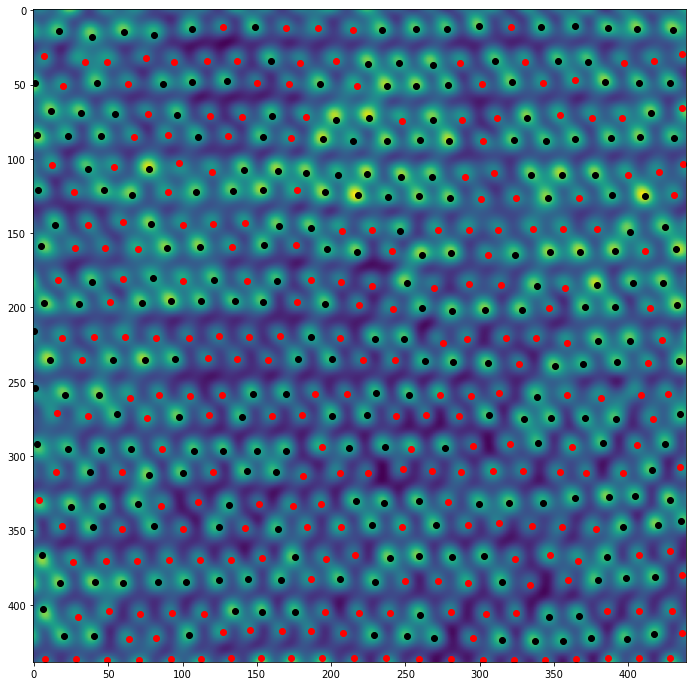

In [7]:
#We previously used px atom motif matching to find these atoms...
# We will load these here. 
atom_positions = np.load('atom_positions.npy')

atoms_found = []
atom_types = [] #list of atom types (0 or 1, for Mo or Re)

#We will be cycling through the atomic positions and using 
#a hard threshold to distinguish beteen Mo and Re atoms
for ind in range(atom_positions.shape[0]):
    
    atom_x = atom_positions[ind,1]
    atom_y = atom_positions[ind,0]
    
    mean_int = data_re55[int(atom_y)-2:int(atom_y)+2, int(atom_x)-2:int(atom_x)+2].mean()
    
    atoms_found.append((atom_x,atom_y))
    
    if mean_int<0.60:
        atom_types.append(0)
    else:
        atom_types.append(1)

atom_pos = np.array(atoms_found)
atom_types = np.array(atom_types)

#Plot the atoms found
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(data_re55)
ax.plot(atom_pos[:,0][atom_types==0], atom_pos[atom_types==0][:,1], 'ro')
ax.plot(atom_pos[atom_types==1][:,0], atom_pos[atom_types==1][:,1], 'ko')

## Perform Local crystallography

For this, we take the image, the atomic coordinates, the atom types list, and some other parameters and pass them to the "Atoms" class to instantialte an Atoms object. This object has methods for performing and plotting local crystallography. 

Failed Fit


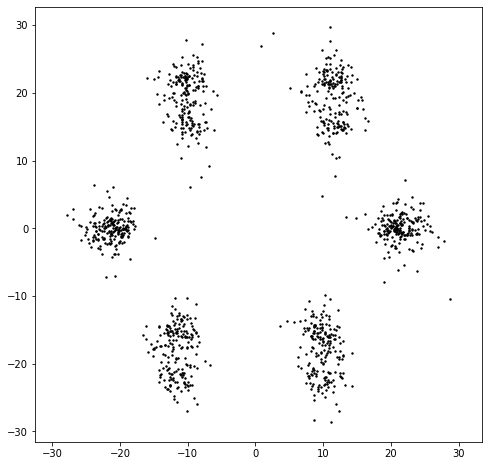

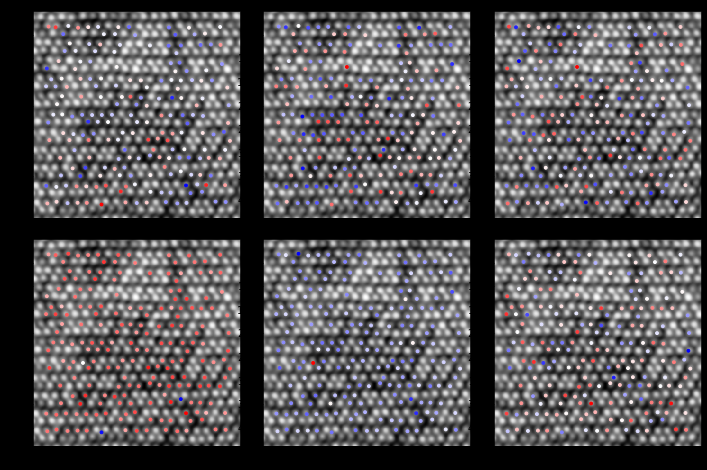

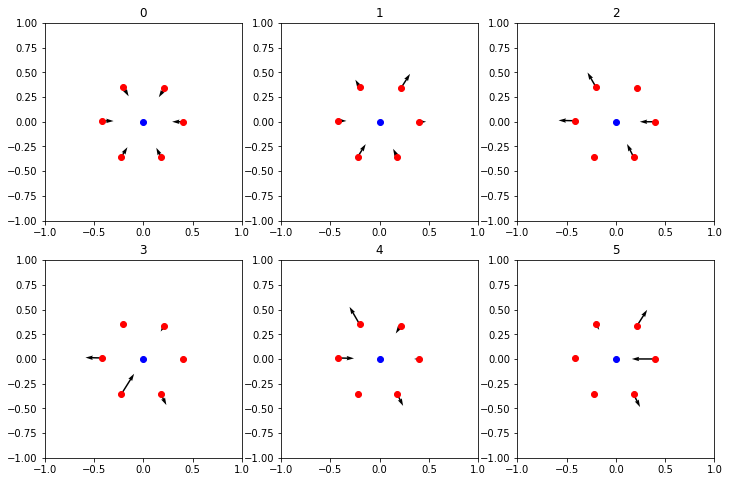

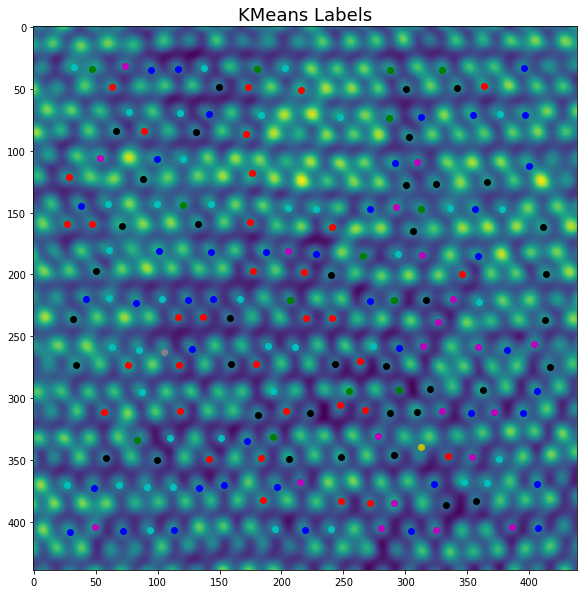

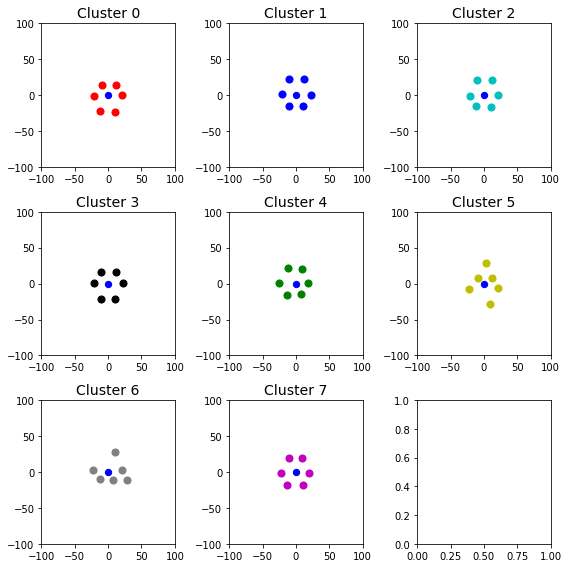

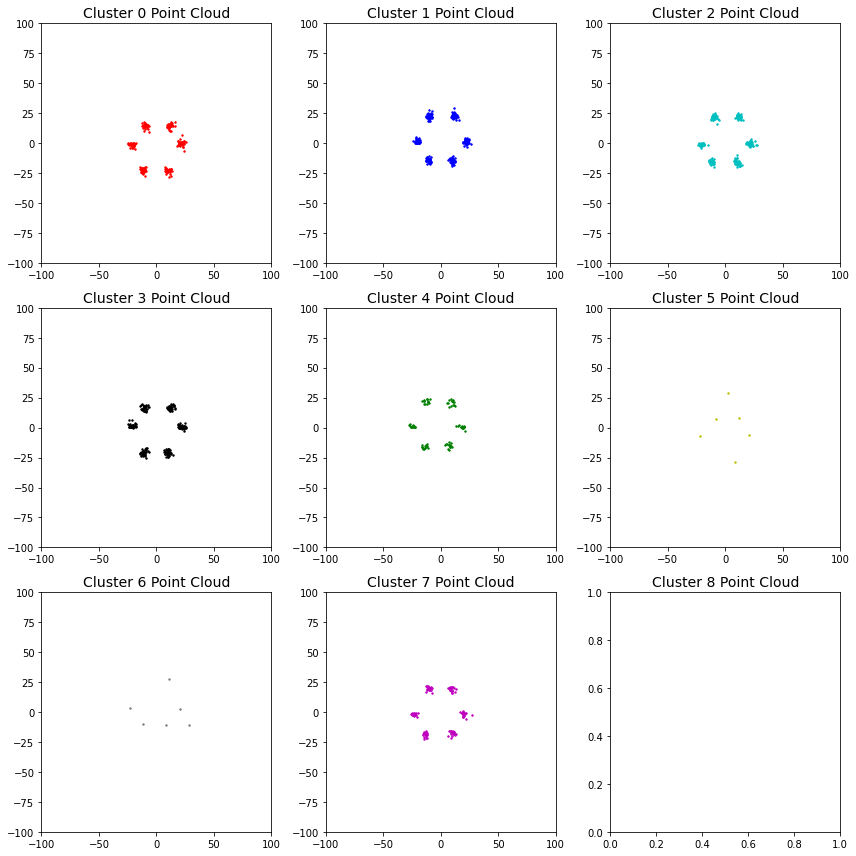

In [8]:
atoms_re55 = Atoms(data_re55, np.array(atom_pos), 
          atom_types = atom_types,atom_descriptors={'Mo':0, 'Re':1},
          border = 0.05, window_size = 14, image_name = '$Mo_{0.45}Re_{0.55}$', comp = 0.55)

#We can refine the atomic positions
_, opt_fits_re55 = atoms_re55.refine_atomic_positions();

#And compute the neighborhoods
atoms_re55.compute_neighborhood(num_neighbors=6, atom_type = 'Mo')

#And finally do PCA and kmeans
atoms_re55.compute_pca_of_neighbors();
atoms_re55.compute_kmeans_neighbors(num_clusters = 8);

# Exercise

Upload your own STEM image, find the atomic coordinates and perform the local crystallography to get an idea how it works...